In [1]:
%reload_ext autoreload
%reload_ext line_profiler

In [2]:
%autoreload 2
import environments.ControlledRangeVariance
import numpy as np

def getenv(wsq, tv=None):
    wsupport = [ 0, 0.5, 2, 100 ]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=90210, wsupport=wsupport, expwsq=wsq, tv=tv)
    return env, env.getpw(), env.range(), env.expectedwsq()

env, pw, rng, ewsq = getenv(10)
tv, data = env.sample(100)
print(len(data))

def compress(data):
    # could be improved but it's used only for debugging.
    sd = sorted(tuple(datum) for datum in data)
    from itertools import groupby
    return [(len(list(g)),)+tuple(map(float,k)) for k, g in groupby(sd)]

print(compress(data))

100
[(26, 0.0, 0.0), (1, 0.5, 0.0), (20, 0.5, 1.0), (2, 2.0, 0.0), (51, 2.0, 1.0)]


In [3]:
def produce_results(env, method, alpha, ndata=100, reps=10):
    wmin, wmax = env.range()
    ubd = np.zeros(ndata)
    lbd = np.zeros(ndata)
    cov = np.zeros((reps, ndata))
    width = np.zeros((reps, ndata))
    bounds = []
    for i in range(reps):
        (truevalue, data) = env.sample(ndata)
        try:
            cs = method(data=data, wmin=wmin, wmax=wmax, alpha=alpha)
            assert np.isfinite(cs[0]).all() and np.isfinite(cs[1]).all()
            assert np.all(cs[1] >= cs[0]-1e-4)
            assert cs[1][-1] <= 1 + 1e-4
            assert cs[0][-1] >= -1e-4
        except:
            import json
            with open('bad_case.json','w') as out:
                perm_state = list(env.perm_state)
                perm_state[1] = list(map(int,perm_state[1]))
                out.write(json.dumps((float(truevalue), compress(data), perm_state, float(wmin), float(wmax), alpha)))
            print('truevalue was {}'.format(truevalue))
            print('data was {}'.format(compress(data)))
            print('wmin, wmax was {} {}'.format(wmin, wmax))
            print('ci was {} {}'.format(cs[0][-1],cs[1][-1]))
            raise
        np.greater_equal(cs[1], truevalue, out=ubd)
        np.less_equal(cs[0], truevalue, out=lbd)
        cov[i, :] = ubd * lbd
        width[i, :] += np.subtract(cs[1], cs[0])
        bounds.append((truevalue, cs[0], cs[1]))

    upper_ends = [ d[2][-1] for d in bounds ]
    lower_ends = [ d[1][-1] for d in bounds ]
    upperbounded = [ 1 if d[0] <= d[2][-1] else 0 for d in bounds ]
    lowerbounded = [ 1 if d[1][-1] <= d[0] else 0 for d in bounds ]
    covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
    final_width = [ d[2][-1] - d[1][-1] for d in bounds ]    
    
    def std_mean(x):
        return np.std(x, ddof=1) / np.sqrt(len(x) - 1)
    
    dbg = {   
            'cov': np.mean(covered),
            'covstd': std_mean(covered),
            'ubcov': np.mean(upperbounded),
            'lbcov': np.mean(lowerbounded),
            'final_width': np.mean(final_width),
            'widthstd': std_mean(final_width),
            'widthlo': np.quantile(final_width, q=[0.05])[0],
            'widthhi': np.quantile(final_width, q=[0.95])[0],
            'ub': np.mean(upper_ends),
            'lb': np.mean(lower_ends),
        }
    
    verbose=True
    if verbose:
        print('{}'.format((ndata, { k: np.round(v, 4) for k, v in dbg.items() })), flush=True)
    
    return  (ndata, 
             {
                'cov':   np.mean(cov, axis=0),
                'covstd': np.std(cov, axis=0, ddof=1) / np.sqrt(cov.shape[0] - 1),
                'width': np.mean(width, axis=0),
                'widtstd': np.std(width, axis=0, ddof=1) / np.sqrt(width.shape[0] - 1),
             },
            )

In [4]:
def trivial(data, wmin, wmax, alpha):
    n = len(data)
    return np.zeros(n), np.ones(n)

from opebet import wealth_lb_1d, wealth_lb_2d

def bet_1d(data, wmin, wmax, alpha):
    lb, ub = wealth_lb_1d(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

def bet_2d(data, wmin, wmax, alpha):
    lb, ub = wealth_lb_2d(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

def evaluate(method, alpha, ndata, reps, wsq, tv=None):
    env, _, _, _ = getenv(wsq, tv)
    z = produce_results(env, method, alpha, ndata, reps) 
    return z

In [5]:
def do_debug():
    import json
    with open('bad_case.json') as inp:
        js = json.loads(inp.read())
    truevalue, compressed_data, perm_state, wmin, wmax, alpha = js
    perm_state[1] = np.array(perm_state[1], dtype=np.uint32)
    rs = np.random.RandomState()
    rs.set_state(tuple(perm_state))
    perm = rs.permutation(1000)
    wr = np.empty((1000, 2), dtype=np.float64)
    offset = 0
    for c, w, r in compressed_data:
        slc = perm[offset:offset+c]
        wr[slc, 0] = w
        wr[slc, 1] = r
        offset += c

    lb, ub = non_trivial(data=wr, wmin=wmin, wmax=wmax, alpha=alpha)

In [6]:
res2d = evaluate(bet_2d, alpha=0.05, ndata=100000, reps=1000, wsq=10)

(100000, {'cov': 0.952, 'covstd': 0.0068, 'ubcov': 0.979, 'lbcov': 0.973, 'final_width': 0.0568, 'widthstd': 0.0011, 'widthlo': 0.02, 'widthhi': 0.1152, 'ub': 0.5297, 'lb': 0.4728})


In [7]:
res1d = evaluate(bet_1d, alpha=0.05, ndata=100000, reps=1000, wsq=10)

(100000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.1873, 'widthstd': 0.0023, 'widthlo': 0.1152, 'widthhi': 0.3568, 'ub': 0.6026, 'lb': 0.4153})


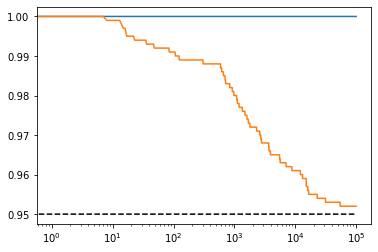

In [8]:
def plot(coverage, *args):
    from matplotlib import pyplot as plt
    %matplotlib inline
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    for arg in args:
        ax.plot(np.arange(arg.size),arg)
    ax.plot(np.arange(arg.size),coverage*np.ones_like(arg),'k--')
    
plot(0.95,res1d[1]['cov'],res2d[1]['cov'])

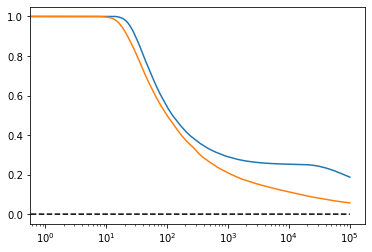

In [9]:
plot(0,res1d[1]['width'],res2d[1]['width'])

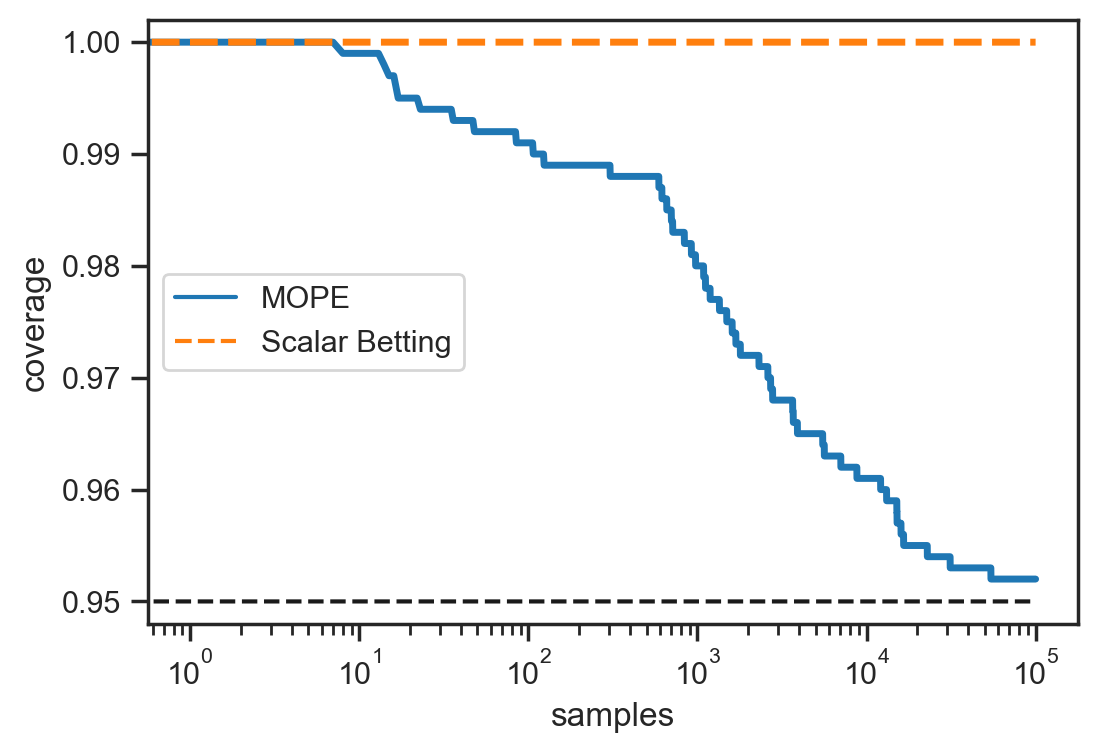

In [35]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

sns.set_theme(style='ticks')
values = np.stack((res2d[1]['cov'],res1d[1]['cov']), axis=1)
columns = ["MOPE", "Scalar Betting"]
data = pd.DataFrame(values, columns=columns)
fig, ax = plt.subplots(dpi=200)
sns.lineplot(data=data, palette="tab10", linewidth=2.5, ci=None, ax=ax)
ax.plot(np.arange(res1d[1]['cov'].size),0.95*np.ones_like(res1d[1]['cov']),'k--')
ax.set(xscale="log", xlabel="samples", ylabel="coverage", ylim=(0.948,1.002))
fig.savefig('coverage.pdf', bbox_inches='tight', pad_inches=0)
#ax.legend(loc='center right')